In [85]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [86]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [87]:
tf.keras.backend.clear_session()

In [88]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [89]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [90]:
subject = 'Roraima - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [91]:
data = pd.read_csv('2003_mo_model_input_RR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima - Consumo de Cimento (t),Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.734916,0.737579,6.920,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.734957,0.737903,7.476,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.734998,0.738226,8.659,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.735038,0.738550,7.259,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.735079,0.738873,6.786,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


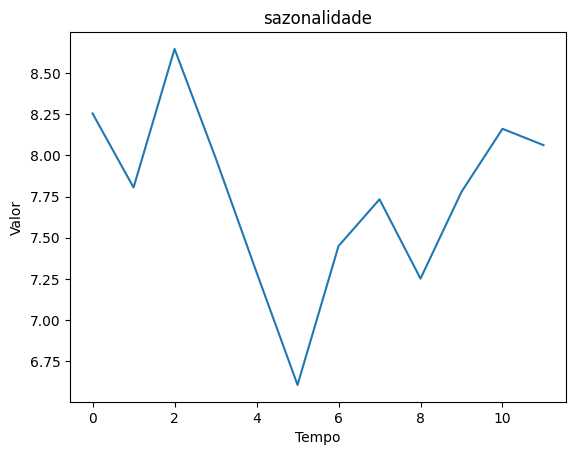

,sazonalidade
sazonalidade,
0,8.254748
1,7.805187
2,8.646925
3,7.985925
4,7.290338
5,6.606015
6,7.449672
7,7.733340
8,7.251604


In [92]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [93]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.737579,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.254748,6.920
1,2003-2,0.734957,0.737903,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,7.805187,7.476
2,2003-3,0.734998,0.738226,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.646925,8.659
3,2003-4,0.735038,0.738550,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,7.985925,7.259
4,2003-5,0.735079,0.738873,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,7.290338,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.290338,NaN
245,2023-6,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.606015,NaN
246,2023-7,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.449672,NaN
247,2023-8,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.733340,NaN


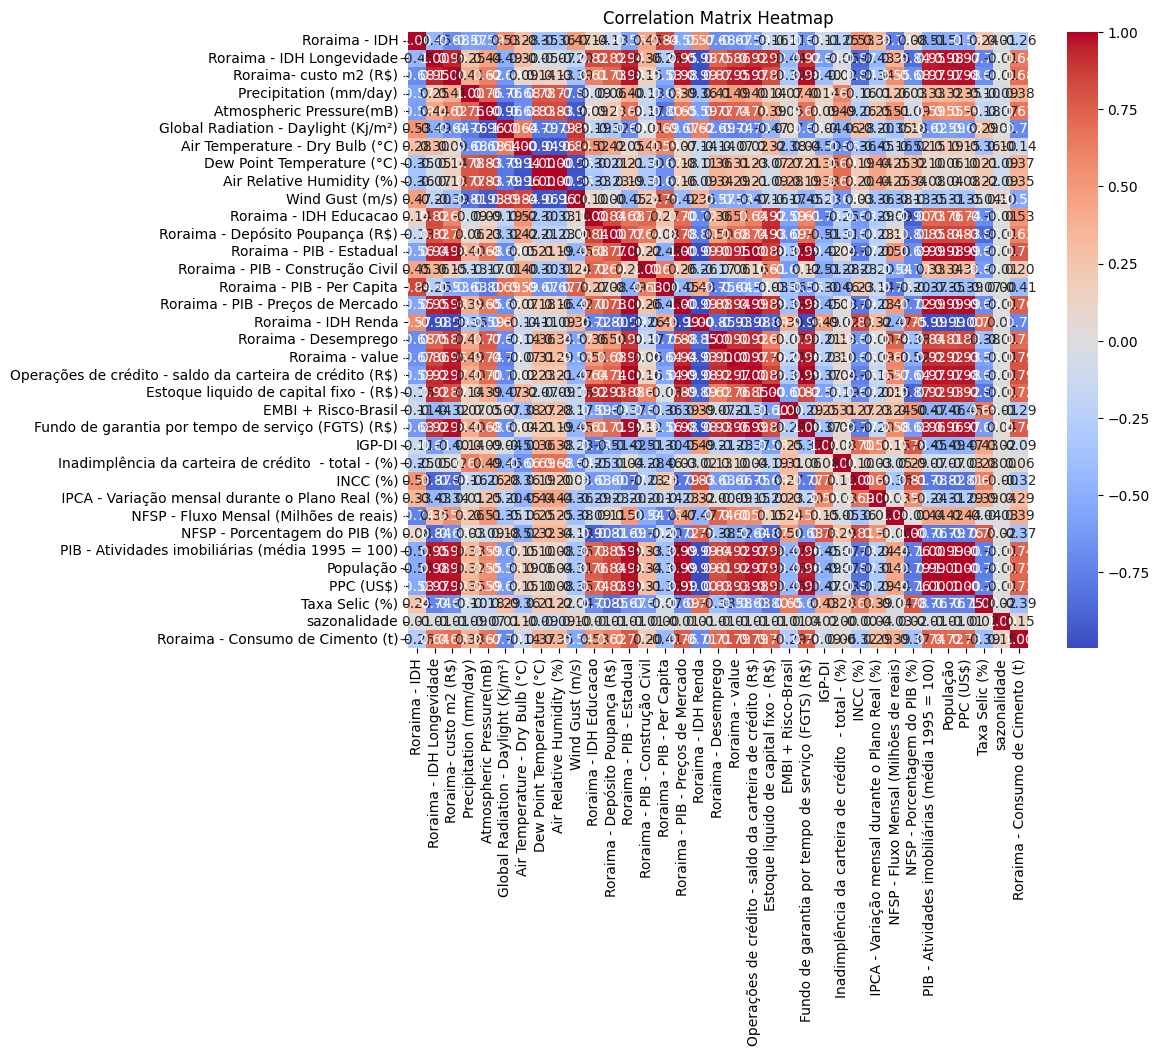

In [94]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [95]:
data =data.drop(['IGP-DI',
                 'Air Temperature - Dry Bulb (°C)'], axis=1)
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.737579,12652.753600,2.058778,1001.077198,1671.347636,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.254748,6.920
1,2003-2,0.734957,0.737903,12757.336292,2.058778,1001.079258,1671.347636,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,7.805187,7.476
2,2003-3,0.734998,0.738226,12860.789996,2.058778,1001.080459,1671.347636,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.646925,8.659
3,2003-4,0.735038,0.738550,12962.516425,2.058778,1001.080588,1671.347636,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,7.985925,7.259
4,2003-5,0.735079,0.738873,13063.753666,2.047445,1001.066958,1673.953674,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,7.290338,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.290338,NaN
245,2023-6,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.606015,NaN
246,2023-7,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.449672,NaN
247,2023-8,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.733340,NaN


In [96]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.346657,-2.343960,-1.642520,0.761168,0.377671,-0.221666,1.507280,1.538942,-1.004155,-2.864861,-1.965389,-1.650047,-2.537523,-1.382546,-1.820180,1.865293,-0.695651,-0.837394,-1.361787,-2.389042,-0.582420,-1.347324,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.966353
1,-0.316945,-2.301111,-1.617562,0.761168,0.378771,-0.221666,1.504467,1.538942,-1.003224,-2.798425,-1.958249,-1.633241,-2.453668,-1.340990,-1.796532,1.842221,-0.700839,-0.805077,-1.361224,-2.352139,-0.799075,-1.380245,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,0.101819
2,-0.287234,-2.258262,-1.592873,0.761168,0.379413,-0.221666,1.502826,1.538942,-1.002681,-2.731990,-1.951109,-1.616435,-2.369814,-1.299433,-1.772885,1.819148,-0.706028,-0.776961,-1.361187,-2.315236,-0.618584,-1.392954,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,1.720533
3,-0.257523,-2.215413,-1.568597,0.761168,0.379482,-0.221666,1.502650,1.538942,-1.002622,-2.665554,-1.943969,-1.599629,-2.285960,-1.257877,-1.749238,1.796075,-0.711217,-0.753079,-1.360756,-2.278333,-0.139520,-1.396056,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,0.449388
4,-0.227812,-2.172563,-1.544437,0.749354,0.372198,-0.211846,1.488028,1.526340,-0.991047,-2.599119,-1.936829,-1.582822,-2.202105,-1.216320,-1.725591,1.773002,-0.716406,-0.730102,-1.359394,-2.241431,0.494336,-1.388786,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.888269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-3.166795,1.089947,1.848672,2.410241,0.922592,-0.690178,0.650907,0.590791,-0.970648,-0.600044,0.786994,1.253468,-0.612057,-1.780820,1.251634,-1.399796,1.267469,1.568039,1.316363,0.389193,-0.244459,1.237409,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,-0.036348
188,-3.318917,1.070420,1.874241,2.178232,0.743729,-0.623222,0.485064,0.445193,-0.781727,-0.679703,0.827518,1.245588,-0.616438,-1.802446,1.242511,-1.398268,1.252097,1.600280,1.330590,0.370392,-0.199028,1.214214,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,-0.962757
189,-3.471040,1.050893,1.900684,1.345019,0.730056,-0.584363,0.248499,0.234427,-0.563592,-0.759362,0.868042,1.237708,-0.620818,-1.824072,1.233388,-1.396740,1.236726,1.635777,1.352241,0.351592,-0.173807,1.409043,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.050999
190,-3.623162,1.031366,1.927962,0.715249,0.804149,-0.599296,0.010725,0.092211,-0.295963,-0.839021,0.908567,1.229828,-0.625199,-1.845698,1.224265,-1.395212,1.221354,1.674397,1.370978,0.332791,-0.169867,1.654237,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.787423


In [97]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      5.753
1      5.006
2      5.470
3      1.513
4      3.706
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Roraima - Consumo de Cimento (t), Length: 249, dtype: float64

In [98]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.346657,-2.343960,-1.642520,0.761168,0.377671,-0.221666,1.507280,1.538942,-1.004155,-2.864861,-1.965389,-1.650047,-2.537523,-1.382546,-1.820180,1.865293,-0.695651,-0.837394,-1.361787,-2.389042,-0.582420,-1.347324,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.966353
1,-0.316945,-2.301111,-1.617562,0.761168,0.378771,-0.221666,1.504467,1.538942,-1.003224,-2.798425,-1.958249,-1.633241,-2.453668,-1.340990,-1.796532,1.842221,-0.700839,-0.805077,-1.361224,-2.352139,-0.799075,-1.380245,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,0.101819
2,-0.287234,-2.258262,-1.592873,0.761168,0.379413,-0.221666,1.502826,1.538942,-1.002681,-2.731990,-1.951109,-1.616435,-2.369814,-1.299433,-1.772885,1.819148,-0.706028,-0.776961,-1.361187,-2.315236,-0.618584,-1.392954,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,1.720533
3,-0.257523,-2.215413,-1.568597,0.761168,0.379482,-0.221666,1.502650,1.538942,-1.002622,-2.665554,-1.943969,-1.599629,-2.285960,-1.257877,-1.749238,1.796075,-0.711217,-0.753079,-1.360756,-2.278333,-0.139520,-1.396056,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,0.449388
4,-0.227812,-2.172563,-1.544437,0.749354,0.372198,-0.211846,1.488028,1.526340,-0.991047,-2.599119,-1.936829,-1.582822,-2.202105,-1.216320,-1.725591,1.773002,-0.716406,-0.730102,-1.359394,-2.241431,0.494336,-1.388786,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.888269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.256163,1.469782,1.093603,0.031956,0.785476,-0.833372,0.091794,0.002360,-0.336021,1.315321,0.203166,1.210022,-0.560021,-0.995787,1.154680,-1.292536,1.464445,1.181073,1.335787,0.819304,0.961603,1.338424,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,0.101819
158,-0.349321,1.462188,1.116547,0.354081,1.057752,-0.930306,0.299639,0.248080,-0.554339,1.252223,0.209449,1.218026,-0.570604,-1.003856,1.167190,-1.298372,1.447722,1.186391,1.325546,0.808136,1.030624,1.300351,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,1.720533
159,-0.442479,1.454594,1.139539,1.036846,1.253094,-1.108416,0.660202,0.639967,-0.823699,1.189126,0.215733,1.226031,-0.581187,-1.011926,1.179699,-1.304209,1.430999,1.191228,1.315396,0.796969,1.039183,1.250508,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,0.449388
160,-0.535637,1.447001,1.163843,1.063091,1.460882,-1.111202,0.811740,0.824030,-0.980955,1.126028,0.222016,1.234036,-0.591770,-1.019995,1.192209,-1.310045,1.414277,1.195247,1.306664,0.785801,1.017171,1.240363,1.048868,-1.103668,-0.614500,1.147619,-0.640320,0.956331,1.065381,1.083626,0.392942,-0.888269


In [99]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       5.753
1       5.006
2       5.470
3       1.513
4       3.706
        ...  
157     6.557
158     8.184
159     8.092
160     7.806
161    10.831
Name: Roraima - Consumo de Cimento (t), Length: 162, dtype: float64

In [100]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [101]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 32)

In [102]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.330327,0.414108,0.404366,1.509014,1.084239,-1.005309,0.950345,0.976156,-1.059559,0.640060,1.204305,0.751030,1.060935,0.050149,0.761717,-0.625818,0.763630,0.559901,0.722924,0.944085,-0.882533,0.551812,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,-0.581860
127,0.319821,0.415347,0.424000,1.166096,0.754167,-0.904159,0.951498,0.910380,-1.059965,0.640832,1.161988,0.769813,0.950350,0.001472,0.775053,-0.625883,0.820001,0.589214,0.745258,0.947319,-0.815413,0.566622,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,-0.036348
128,0.309316,0.416587,0.444348,0.565454,0.551876,-0.779402,0.854555,0.757541,-0.938565,0.641604,1.119671,0.788597,0.839766,-0.047205,0.788390,-0.625949,0.876373,0.618740,0.767990,0.950553,-0.745839,0.568617,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,-0.962757
129,0.298810,0.417826,0.468872,0.169724,0.439059,-0.762598,0.616032,0.566065,-0.733777,0.642376,1.077354,0.807381,0.729182,-0.095883,0.801726,-0.626015,0.932744,0.648481,0.799035,0.953786,-0.687348,0.719776,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,0.050999
130,0.288304,0.419065,0.489635,-0.058006,0.341615,-0.831561,0.415990,0.408141,-0.508176,0.643149,1.035037,0.826164,0.618597,-0.144560,0.815063,-0.626081,0.989115,0.678511,0.830824,0.957020,-0.639220,0.905478,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.787423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-3.166795,1.089947,1.848672,2.410241,0.922592,-0.690178,0.650907,0.590791,-0.970648,-0.600044,0.786994,1.253468,-0.612057,-1.780820,1.251634,-1.399796,1.267469,1.568039,1.316363,0.389193,-0.244459,1.237409,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,-0.036348
188,-3.318917,1.070420,1.874241,2.178232,0.743729,-0.623222,0.485064,0.445193,-0.781727,-0.679703,0.827518,1.245588,-0.616438,-1.802446,1.242511,-1.398268,1.252097,1.600280,1.330590,0.370392,-0.199028,1.214214,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,-0.962757
189,-3.471040,1.050893,1.900684,1.345019,0.730056,-0.584363,0.248499,0.234427,-0.563592,-0.759362,0.868042,1.237708,-0.620818,-1.824072,1.233388,-1.396740,1.236726,1.635777,1.352241,0.351592,-0.173807,1.409043,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.050999
190,-3.623162,1.031366,1.927962,0.715249,0.804149,-0.599296,0.010725,0.092211,-0.295963,-0.839021,0.908567,1.229828,-0.625199,-1.845698,1.224265,-1.395212,1.221354,1.674397,1.370978,0.332791,-0.169867,1.654237,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.787423


In [103]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 32)

In [104]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [105]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [106]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(20)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [107]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2792633004, 1402534610, 1834646672, 2743492150, 1141200377, 242807012, 1380842494, 3938062162, 2726607365, 2343441926, 1621438957, 1533636355, 3804648220, 596615333, 1193021368, 1204034637, 2713529360, 3144335312, 1071143535, 2448580913]


Step: 0 ___________________________________________
val_loss: 2.2475414276123047
winner_seed: 2792633004


Step: 1 ___________________________________________
val_loss: 1.6425096988677979
winner_seed: 1402534610


Step: 2 ___________________________________________
val_loss: 2.8731093406677246


Step: 3 ___________________________________________
val_loss: 2.662917137145996


Step: 4 ___________________________________________
val_loss: 2.3588924407958984


Step: 5 ___________________________________________
val_loss: 2.9108526706695557


Step: 6 ___________________________________________
val_loss: 2.2417986392974854


Step: 7 ___________________________________________
val_loss: 2.60976243019104


Step: 8 __________________________________________

In [108]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 3s 187ms/step - loss: 102.3500 - val_loss: 112.0533
Epoch 2/10000
4/4 [==============================] - 0s 15ms/step - loss: 73.7316 - val_loss: 94.8117
Epoch 3/10000
4/4 [==============================] - 0s 14ms/step - loss: 58.7016 - val_loss: 74.4525
Epoch 4/10000
4/4 [==============================] - 0s 14ms/step - loss: 52.5957 - val_loss: 53.8292
Epoch 5/10000
4/4 [==============================] - 0s 13ms/step - loss: 50.0595 - val_loss: 54.4395
Epoch 6/10000
4/4 [==============================] - 0s 14ms/step - loss: 48.9734 - val_loss: 48.3801
Epoch 7/10000
4/4 [==============================] - 0s 14ms/step - loss: 47.9517 - val_loss: 47.3441
Epoch 8/10000
4/4 [==============================] - 0s 13ms/step - loss: 47.7805 - val_loss: 46.8291
Epoch 9/10000
4/4 [==============================] - 0s 14ms/step - loss: 47.0986 - val_loss: 46.1308
Epoch 10/10000
4/4 [==============================] - 0s 14ms/step - loss: 47.1

4/4 [==============================] - 0s 14ms/step - loss: 33.7294 - val_loss: 34.1107
Epoch 81/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.5157 - val_loss: 34.3271
Epoch 82/10000
4/4 [==============================] - 0s 15ms/step - loss: 33.4047 - val_loss: 33.8540
Epoch 83/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.2609 - val_loss: 33.9520
Epoch 84/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.0168 - val_loss: 34.0474
Epoch 85/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.8627 - val_loss: 33.4596
Epoch 86/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.7100 - val_loss: 33.6192
Epoch 87/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.5327 - val_loss: 33.0579
Epoch 88/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.4178 - val_loss: 33.4540
Epoch 89/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.2198 - val

4/4 [==============================] - 0s 12ms/step - loss: 21.9965 - val_loss: 23.1208
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.6717 - val_loss: 23.7668
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.5499 - val_loss: 23.6251
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.5040 - val_loss: 23.6335
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.3717 - val_loss: 23.1688
Epoch 164/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.4064 - val_loss: 23.1678
Epoch 165/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.0974 - val_loss: 22.5235
Epoch 166/10000
4/4 [==============================] - 0s 15ms/step - loss: 21.1215 - val_loss: 22.6675
Epoch 167/10000
4/4 [==============================] - 0s 15ms/step - loss: 20.8631 - val_loss: 22.6057
Epoch 168/10000
4/4 [==============================] - 0s 15ms/step - loss: 20.6

Epoch 238/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.7500 - val_loss: 15.6232
Epoch 239/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.7699 - val_loss: 14.8255
Epoch 240/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.7493 - val_loss: 15.0977
Epoch 241/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.4777 - val_loss: 15.3776
Epoch 242/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.3703 - val_loss: 15.4082
Epoch 243/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.3254 - val_loss: 14.4939
Epoch 244/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.1246 - val_loss: 15.2412
Epoch 245/10000
4/4 [==============================] - 0s 15ms/step - loss: 12.2015 - val_loss: 13.9991
Epoch 246/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.3560 - val_loss: 14.1498
Epoch 247/10000
4/4 [==============================] - 0s 14ms/s

4/4 [==============================] - 0s 13ms/step - loss: 6.4266 - val_loss: 9.9516
Epoch 318/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.7834 - val_loss: 8.8355
Epoch 319/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.4048 - val_loss: 9.3576
Epoch 320/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.5056 - val_loss: 9.2401
Epoch 321/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.2523 - val_loss: 8.7485
Epoch 322/10000
4/4 [==============================] - 0s 15ms/step - loss: 6.2253 - val_loss: 8.4594
Epoch 323/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.0666 - val_loss: 8.6702
Epoch 324/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.2579 - val_loss: 8.7234
Epoch 325/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.0168 - val_loss: 8.2696
Epoch 326/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.8613 - val_loss: 8.5

4/4 [==============================] - 0s 14ms/step - loss: 2.8689 - val_loss: 5.5366
Epoch 398/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.8940 - val_loss: 5.0984
Epoch 399/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.0118 - val_loss: 6.2097
Epoch 400/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.8645 - val_loss: 6.0664
Epoch 401/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.8359 - val_loss: 5.2519
Epoch 402/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.7123 - val_loss: 4.7568
Epoch 403/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.7765 - val_loss: 5.2573
Epoch 404/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.7619 - val_loss: 5.7539
Epoch 405/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.7571 - val_loss: 4.9916
Epoch 406/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.6719 - val_loss: 6.1

4/4 [==============================] - 0s 14ms/step - loss: 2.1590 - val_loss: 4.2882
Epoch 478/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8909 - val_loss: 3.6053
Epoch 479/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8013 - val_loss: 4.2903
Epoch 480/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.9497 - val_loss: 5.3530
Epoch 481/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.1264 - val_loss: 4.1090
Epoch 482/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8197 - val_loss: 4.5232
Epoch 483/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.8680 - val_loss: 5.6397
Epoch 484/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8250 - val_loss: 5.1974
Epoch 485/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.8147 - val_loss: 5.1273
Epoch 486/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.0723 - val_loss: 4.4

4/4 [==============================] - 0s 14ms/step - loss: 1.7265 - val_loss: 5.5610
Epoch 558/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.3521 - val_loss: 5.1898
Epoch 559/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.6895 - val_loss: 5.2194
Epoch 560/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.6527 - val_loss: 5.0487
Epoch 561/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6785 - val_loss: 5.1366
Epoch 562/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8326 - val_loss: 3.9993
Epoch 563/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6711 - val_loss: 5.1804
Epoch 564/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8954 - val_loss: 5.0049
Epoch 565/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.6497 - val_loss: 4.5693
Epoch 566/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.6624 - val_loss: 4.5

4/4 [==============================] - 0s 14ms/step - loss: 1.5702 - val_loss: 4.9515
Epoch 638/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.5601 - val_loss: 4.6861
Epoch 639/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.5462 - val_loss: 4.7400
Epoch 640/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.7835 - val_loss: 4.9907
Epoch 641/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.5018 - val_loss: 5.4958
Epoch 642/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.5674 - val_loss: 4.3926
Epoch 643/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.6059 - val_loss: 4.8081
Epoch 644/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6343 - val_loss: 5.9846
Epoch 645/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6411 - val_loss: 4.8147
Epoch 646/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6198 - val_loss: 4.4

4/4 [==============================] - 0s 14ms/step - loss: 1.5051 - val_loss: 4.2562
Epoch 718/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.8177 - val_loss: 4.6151
Epoch 719/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4515 - val_loss: 5.0999
Epoch 720/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.5369 - val_loss: 4.6226
Epoch 721/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4666 - val_loss: 5.0366
Epoch 722/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.5105 - val_loss: 5.2170
Epoch 723/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4919 - val_loss: 4.6673
Epoch 724/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.5602 - val_loss: 4.5836
Epoch 725/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6717 - val_loss: 4.4937
Epoch 726/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.7699 - val_loss: 4.9

4/4 [==============================] - 0s 13ms/step - loss: 1.5088 - val_loss: 5.6845
Epoch 798/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.5596 - val_loss: 5.4359
Epoch 799/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.4805 - val_loss: 5.2858
Epoch 800/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.4628 - val_loss: 4.5829
Epoch 801/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.4357 - val_loss: 4.7452
Epoch 802/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.4048 - val_loss: 4.4758
Epoch 803/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8048 - val_loss: 5.0437
Epoch 804/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.6939 - val_loss: 4.2097
Epoch 805/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.5227 - val_loss: 4.5215
Epoch 806/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.5629 - val_loss: 4.9

4/4 [==============================] - 0s 14ms/step - loss: 1.4320 - val_loss: 4.1511
Epoch 878/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4254 - val_loss: 4.3195
Epoch 879/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4243 - val_loss: 5.1973
Epoch 880/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6316 - val_loss: 4.1642
Epoch 881/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4767 - val_loss: 4.2898
Epoch 882/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.3858 - val_loss: 5.4856
Epoch 883/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.4614 - val_loss: 5.0427
Epoch 884/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.5628 - val_loss: 4.8554
Epoch 885/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.3891 - val_loss: 4.3664
Epoch 886/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4124 - val_loss: 4.4

4/4 [==============================] - 0s 14ms/step - loss: 1.4067 - val_loss: 4.3319
Epoch 958/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.3619 - val_loss: 3.9202
Epoch 959/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.6257 - val_loss: 4.9837
Epoch 960/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4078 - val_loss: 4.5334
Epoch 961/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.3706 - val_loss: 4.9181
Epoch 962/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4213 - val_loss: 4.4521
Epoch 963/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.6483 - val_loss: 4.0861
Epoch 964/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.3507 - val_loss: 5.0538
Epoch 965/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.3871 - val_loss: 4.4069
Epoch 966/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4037 - val_loss: 4.3

In [109]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [110]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 24ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,8.312605,8.287465,8.265255,8.244525,8.225656,8.208827,8.194432,8.184393,8.177803,8.173414,8.171876,8.168818,8.166843,8.173271,8.188515,8.227288,8.296971,8.421924,8.640021,8.94571,9.31393,9.644642,9.862152,10.004228,10.116055,10.240754,10.339443,10.420978,10.477894,10.514302
Target,7.703,8.956,8.626,6.735,9.161,8.634,7.115,2.781,7.49,7.043,4.877,7.031,5.988,7.275,9.468,7.97,7.866,8.108,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,0.609605,0.668535,0.360745,1.509525,0.935345,0.425173,1.079432,5.403393,0.687803,1.130414,3.294876,1.137817,2.178843,0.898271,1.279486,0.257288,0.430971,0.313924,1.267979,1.777289,1.31107,0.948359,0.818848,2.117228,0.365055,0.586754,0.917443,0.739022,0.013106,0.289302


In [111]:
display(mae)
display(mape)

1.1250968

0.18822965

In [112]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [113]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 24ms/step
Ano-0: |Prediction[[98.61507]] - Target[86.152]| =  Error: [[12.463066]]; MAPE:[[0.14466369]]
1/1 [==============================] - 0s 21ms/step
Ano-0: |Prediction[[105.8855]] - Target[107.092]| =  Error: [[1.2065048]]; MAPE:[[0.01126606]]
1/1 [==============================] - 0s 18ms/step
Ano-5: |Prediction[[62.109425]] - Target[60.703]| =  Error: [[1.4064255]]; MAPE:[[0.02316896]]


[array([[12.463066]], dtype=float32),
 array([[1.2065048]], dtype=float32),
 array([[1.4064255]], dtype=float32)]

5.025332

0.05969957